## Step 0: Download the Image from the Given URL, setting up Notebooks
Retrieve the image from this link: [The Mysterious Painting](https://upload.wikimedia.org/wikipedia/en/7/74/PicassoGuernica.jpg)

Next, go through each of the three provided notebooks. Combine them into a new notebook and configure your environment according to the specifications for the tasks below.

## Step 1: Artist Recognition with the SigLip Model
Utilize the SigLIP model(CLIP with Sigmoid activation) to identify the artist of the painting from the list of artists provided below. Display the prediction accuracy. The expected output is the artist's name, denoted as [ARTIST].

Use the following Possible Artist Descriptions for zero-shot classification:
```python
descriptions = [
  "a painting by Leonardo da Vinci",
  "a painting by Michelangelo",
  "a painting by Vincent van Gogh",
  "a painting by Pablo Picasso",
  "a painting by Rembrandt",
  "a painting by Claude Monet"
]
```

## Step 2: Style-Based Object or Scene Generation
Once you've identified the [ARTIST], use this information to run the Stable Diffusion model. Create an object or scene (of your choice) inspired by the style of the identified artist. The output for this step should be an image, labeled as [GEN_IMAGE].

## Step 3: Image Segmentation with SAM Model
Take the generated image [GEN_IMAGE] from the previous step, and apply the SAM model for image segmentation. Present the segmentation masks. The result of this task should be a segmented image, denoted as [SEGMENT]. If you face issues such as CUDA running out of memory during SAM step, try to resize the image to a smaller scale before SAM.


# **Step 0**

In [1]:
!nvidia-smi

Wed Sep 10 15:27:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install required packages
!pip install --upgrade -q git+https://github.com/huggingface/transformers
!pip install diffusers==0.30.2 scipy ftfy accelerate
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/bin/bash: line 1: {sys.executable}: command not found


In [3]:
#Import required packages
import os
import sys

import cv2
from diffusers import StableDiffusionXLPipeline
from IPython.core.display import display, HTML
from PIL import Image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import supervision as sv
from transformers import AutoProcessor, AutoModel
import torch

HOME: /content
/content
mkdir: cannot create directory ‘/content/data’: File exists
/content/data


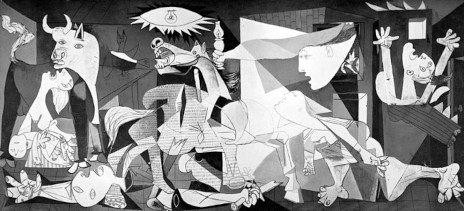

In [4]:
HOME = os.getcwd()
print("HOME:", HOME)

%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://upload.wikimedia.org/wikipedia/en/7/74/PicassoGuernica.jpg

IMAGE_NAME = "PicassoGuernica.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

image = Image.open(IMAGE_PATH).convert("RGB")
image

# **Step 1**

In [5]:
siglip_processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")
siglip_model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384")

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
descriptions = [
  "a painting by Leonardo da Vinci",
  "a painting by Michelangelo",
  "a painting by Vincent van Gogh",
  "a painting by Pablo Picasso",
  "a painting by Rembrandt",
  "a painting by Claude Monet"
]

inputs = siglip_processor(text=descriptions, images=image, padding="max_length", return_tensors="pt")

with torch.no_grad():
  outputs = siglip_model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image)

In [7]:
text_probs = probs[0].cpu().numpy() * 100
max_index = text_probs.argmax()
ARTIST = ' '.join(descriptions[max_index].split(' ')[3:])

print(f"The given picture is a painting by {ARTIST}. Prediction accuracy: {text_probs[max_index]}")

The given picture is a painting by Pablo Picasso. Prediction accuracy: 97.6485824584961


# **Step 2**

In [8]:
diffusion_pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [9]:
diffusion_pipe = diffusion_pipe.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

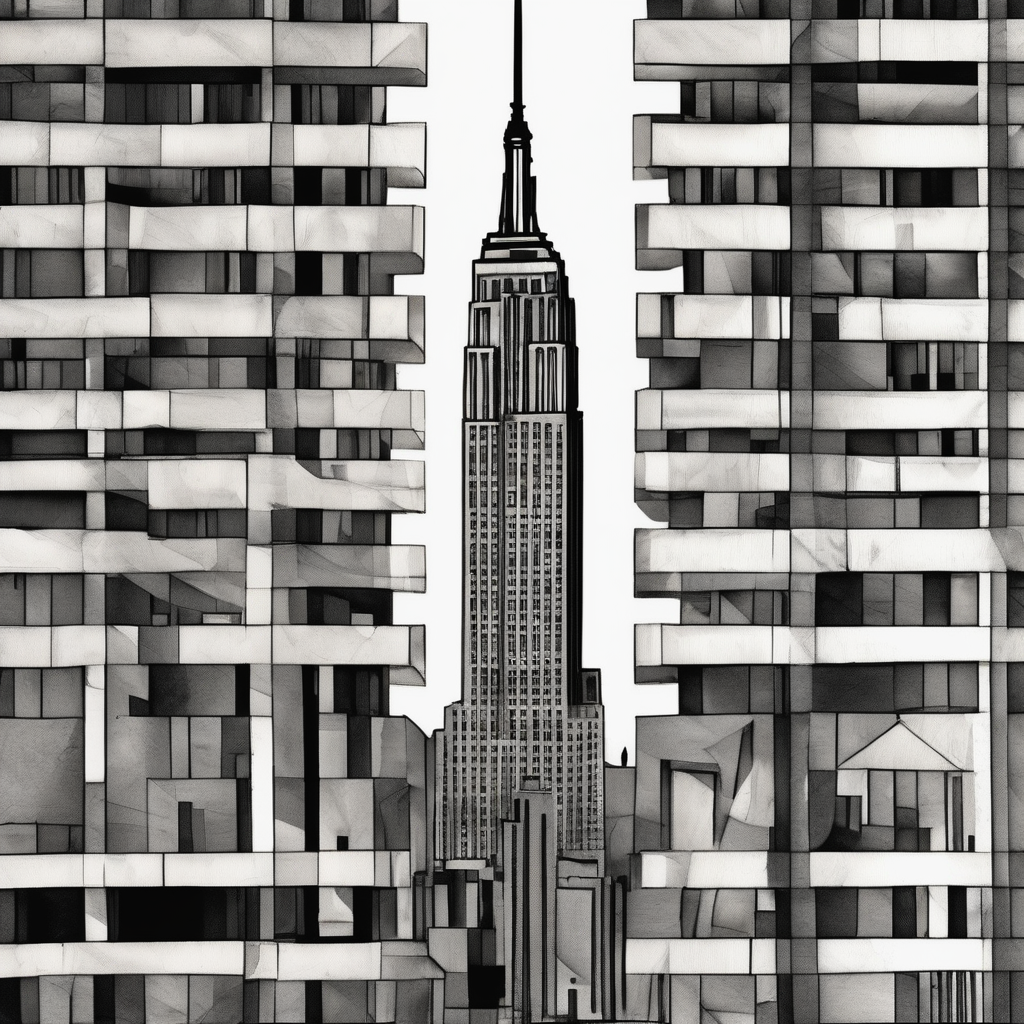

In [10]:
prompt = f"a photograph of empire state building drawn in the style of {ARTIST}"
GEN_IMAGE = diffusion_pipe(prompt).images[0]
GEN_IMAGE

# **Step 3**

In [11]:
%cd {HOME}
GEN_IMAGE_NAME = "generated_image.png"
GEN_IMAGE.save(GEN_IMAGE_NAME)

/content


In [12]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights


In [13]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [14]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [15]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

In [16]:
image_bgr = cv2.imread(os.path.join(HOME, GEN_IMAGE_NAME))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image_rgb)

In [17]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
sam_detections = sv.Detections.from_sam(sam_result=sam_result)

SEGMENT = mask_annotator.annotate(scene=image_bgr.copy(), detections=sam_detections)

Segmented Image


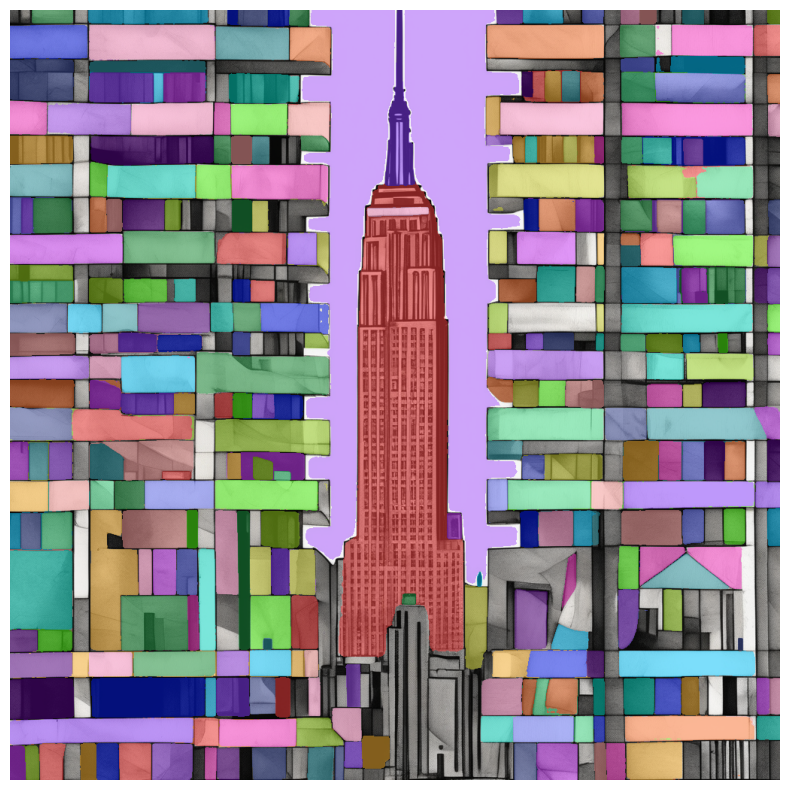

In [18]:
print("Segmented Image")
sv.plot_image(SEGMENT, size=(10, 10))